In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import astropy.units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.table import Table
import regions
from regions import Regions
from spectral_cube import SpectralCube
from astropy.nddata import Cutout2D
from matplotlib.patches import Rectangle

from astropy.visualization.wcsaxes import add_scalebar
from astropy.visualization.wcsaxes import add_beam

In [2]:
from pvextractor import Path, extract_pv_slice

/blue/adamginsburg/adamginsburg/repos/pvextractor/pvextractor/pvregions.py:43: SyntaxWarning: invalid escape sequence '\('
  coordre = re.compile("^[a-z]*\((.*)\)")


In [3]:
basepath = '/orange/adamginsburg/jwst/cloudc/'

In [4]:
cd ..

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament


In [5]:
import cutout_manager as cm
from cutout_manager import get_cutout

In [6]:
cd notebooks/

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


In [7]:
B3_cont_fn = '/orange/adamginsburg/jwst/cloudc/alma/ACES/uid___A001_X15a0_X1a8.s36_0.Sgr_A_star_sci.spw33_35.cont.I.iter1.image.tt0'


# Positions

In [8]:
clump1 = SkyCoord('17:46:19.2287619119', '-28:38:29.2978617171', unit=(u.hourangle, u.deg))
clump2 = SkyCoord('17:46:19.5945777603', '-28:38:09.9402161687', unit=(u.hourangle, u.deg))
clump3 = SkyCoord('17:46:22.0252976019', '-28:37:41.3736076102', unit=(u.hourangle, u.deg))

In [9]:
#cutout_clump1 = cm.get_alma_B3(clump1, 25*u.arcsec, 25*u.arcsec)
#cutout_clump1_rgb = cm.get_cutout_rgb(clump1, 5*u.arcsec, 5*u.arcsec)
#cutout_clump1_rgb3 = cm.get_cutout_rgb3(clump1, 5*u.arcsec, 5*u.arcsec)
#cutout_clump2 = cm.get_alma_B3(clump2, 22*u.arcsec, 22*u.arcsec)
#cutout_clump2_rgb = cm.get_cutout_rgb(clump2, 5*u.arcsec, 5*u.arcsec)
#cutout_clump2_rgb3 = cm.get_cutout_rgb3(clump2, 5*u.arcsec, 5*u.arcsec)
#cutout_clump3 = cm.get_alma_B3(clump3, 25*u.arcsec, 25*u.arcsec)
#cutout_clump3_rgb = cm.get_cutout_rgb(clump3, 5*u.arcsec, 5*u.arcsec)
#cutout_clump3_rgb3 = cm.get_cutout_rgb3(clump3, 5*u.arcsec, 5*u.arcsec)

In [10]:
def get_percentile_list(data, percents=[98, 99, 99.9, 99.99]):
    #[87, 95, 99, 99.5, 99.9, 99.99]
    arr = []
    for per in percents:
        arr.append(np.nanpercentile(data, per))
    return np.array(arr)

In [11]:
pos_ctr = SkyCoord('17:46:20.8194569665', '-28:37:52.4236707380', unit=(u.hourangle, u.deg), frame='icrs')
size_filabox = (2.6762805138*u.arcmin, 86.6778672344*u.arcsec)
l = size_filabox[0]
w = size_filabox[1]
reg_filabox = regions.RectangleSkyRegion(center=pos_ctr, width=size_filabox[1], height=size_filabox[0])

In [12]:
pos_cloudc1 = SkyCoord('17:46:21.3048683891', '-28:35:33.1211282499', unit=(u.hourangle, u.deg))
pos_cloudc2 = SkyCoord('17:46:18.3316118680', '-28:34:48.4717811920', unit=(u.hourangle, u.deg))

pos_cloudd = SkyCoord('17:46:22.6563371259', '-28:33:27.5405071803', unit=(u.hourangle, u.deg))

# Functions

In [13]:
def get_moment0(restfreq, vmin, vmax, filename):
    cube = SpectralCube.read(filename, format='fits')
    subcube = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=restfreq).spectral_slab(vmin, vmax)
    subcube.allow_huge_operations = True
    mom0 = subcube.to(u.K).moment0()
    mom0.allow_huge_operations = True
    return mom0

def get_mom0_cutout(pos, l, w, mom0):
    data = np.squeeze(mom0.data)
    head = mom0.header
    ww = WCS(head).celestial
    size = (l, w)

    cutout = Cutout2D(data, position=pos, size=size, wcs=ww)
    return cutout

def get_moment0_box(pos, l, w, line, vmin, vmax):
    spec_tab = Table.read(f'{basepath}/analysis/linelist.csv')
    mol = spec_tab[spec_tab['Line']==line]
    restfreq = mol['Rest (GHz)'].data[0]*u.GHz
    spw = mol['12m SPW'].data[0]
    cube_fn = f'{basepath}/alma/ACES/uid___A001_X15a0_X1a8.s38_0.Sgr_A_star_sci.spw{spw}.cube.I.iter1.image.pbcor.fits'

    mom0 = get_moment0(restfreq, vmin, vmax, cube_fn)
    mom0_cutout = get_mom0_cutout(pos, l, w, mom0)

    return mom0_cutout

def plot_mom0_cutout(pos, l, w, line, vmin, vmax):
    mom0_cutout = get_moment0_box(pos, l, w, line, vmin, vmax)

    fig = plt.figure(figsize=(8,6))
    ax = plt.subplot(111, projection=mom0_cutout.wcs)
    im = ax.imshow(mom0_cutout.data, cmap='Greys', vmin=0)

    ax.set_xlabel('Right Ascension', fontsize=14)
    ax.set_ylabel('Declination', fontsize=14)
    ax.set_title(line, fontsize=16)

    cbar = plt.colorbar(im)
    cbar.set_label('Integrated Intensity (K km/s)', fontsize=14)
    plt.tight_layout()


    return mom0_cutout


In [14]:
def get_sio_mom0_filament(position, l, w):
    SiO_mom0_fn_lowv = '/orange/adamginsburg/jwst/cloudc/alma/moments/mom0_SiO_B3_n60_n55.fits'
    SiO_mom0_fn_highv = '/orange/adamginsburg/jwst/cloudc/alma/moments/mom0_SiO_B3_n55_n50.fits'
    cutout_lowv = get_cutout(SiO_mom0_fn_lowv, position, l, w)
    cutout_highv = get_cutout(SiO_mom0_fn_highv, position, l, w)
    return cutout_lowv, cutout_highv

def get_cs_mom0_filament(position, l, w):
    SiO_mom0_fn_lowv = '/orange/adamginsburg/jwst/cloudc/alma/moments/mom0_CS_B3_n60_n55.fits'
    SiO_mom0_fn_highv = '/orange/adamginsburg/jwst/cloudc/alma/moments/mom0_CS_B3_n55_n50.fits'
    cutout_lowv = get_cutout(SiO_mom0_fn_lowv, position, l, w)
    cutout_highv = get_cutout(SiO_mom0_fn_highv, position, l, w)
    return cutout_lowv, cutout_highv

def plot_sio_mom0_filament(ax, position, l, w, percents=[70, 80, 90, 95, 98]):
    cutout_lowv, cutout_highv = get_sio_mom0_filament(position, l, w)
    
    ax.contour(cutout_highv.data, transform=ax.get_transform(cutout_highv.wcs), 
               levels=get_percentile_list(cutout_highv.data, percents=percents), 
               colors='red', linewidths=.5)
    ax.contour(cutout_lowv.data, transform=ax.get_transform(cutout_lowv.wcs), 
               levels=get_percentile_list(cutout_lowv.data, percents=percents), 
               colors='blue', linewidths=.5)
    add_beam(ax, header=SpectralCube.read(B3_cont_fn, format='casa').hdu.header, corner='bottom right', color='k', linestyle='dashed', facecolor='none')
    
def plot_cs_mom0_filament(ax, position, l, w, percents=[70, 80, 90, 95, 98]):
    cutout_lowv, cutout_highv = get_cs_mom0_filament(position, l, w)
    
    ax.contour(cutout_highv.data, transform=ax.get_transform(cutout_highv.wcs), 
               levels=get_percentile_list(cutout_highv.data, percents=percents), 
               colors='red', linewidths=.5)
    ax.contour(cutout_lowv.data, transform=ax.get_transform(cutout_lowv.wcs), 
               levels=get_percentile_list(cutout_lowv.data, percents=percents), 
               colors='blue', linewidths=.5)
    add_beam(ax, header=SpectralCube.read(B3_cont_fn, format='casa').hdu.header, corner='bottom right', color='k', linestyle='dashed', facecolor='none')


# Moments

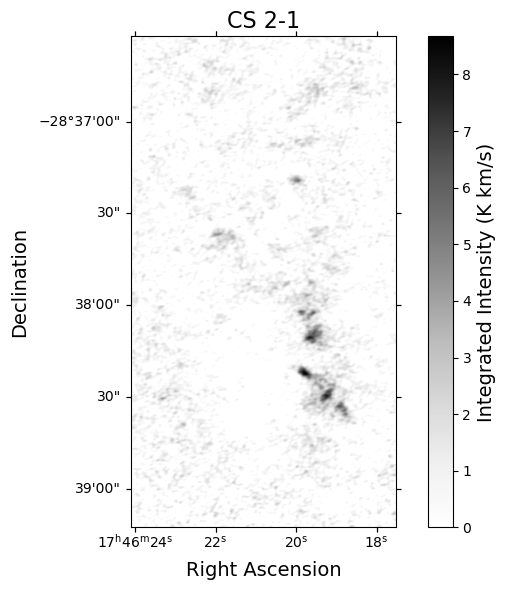

In [15]:
mom0_CS = plot_mom0_cutout(pos_ctr, l, w, line='CS 2-1', vmin=-56*u.km/u.s, vmax=-52*u.km/u.s)
#, vmin=-62*u.km/u.s, vmax=-46*u.km/u.s)
plt.savefig(f'{basepath}/figures/filament_mom0_CS_21.pdf', bbox_inches='tight')

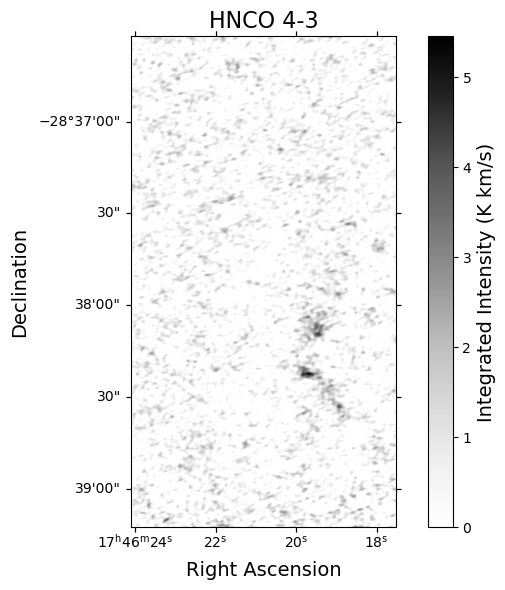

In [24]:
mom0_HNCO = plot_mom0_cutout(pos_ctr, l, w, line='HNCO 4-3', vmin=-56*u.km/u.s, vmax=-52*u.km/u.s)
plt.savefig(f'{basepath}/figures/filament_mom0_HNCO_43.pdf', bbox_inches='tight')

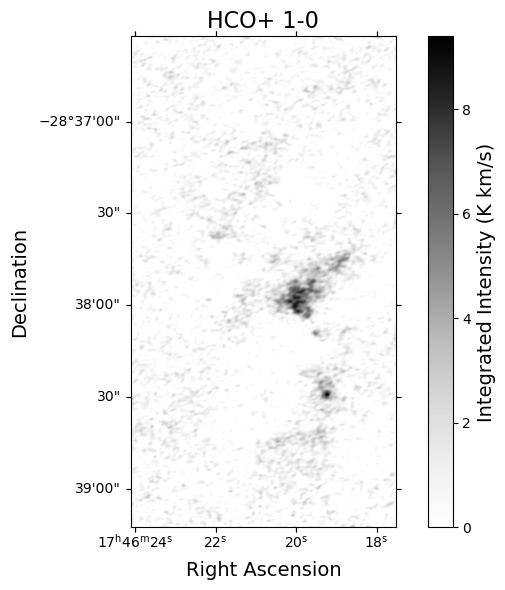

In [25]:
mom0_HCOp = plot_mom0_cutout(pos_ctr, l, w, line='HCO+ 1-0', vmin=-56*u.km/u.s, vmax=-52*u.km/u.s)
plt.savefig(f'{basepath}/figures/filament_mom0_HCOp_10.pdf', bbox_inches='tight')

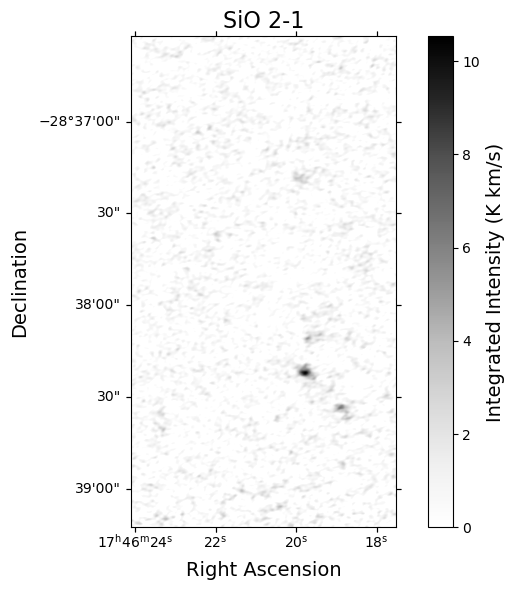

In [26]:
mom0_SiO = plot_mom0_cutout(pos_ctr, l, w, line='SiO 2-1', vmin=-56*u.km/u.s, vmax=-52*u.km/u.s)
plt.savefig(f'{basepath}/figures/filament_mom0_SiO_21.pdf', bbox_inches='tight')

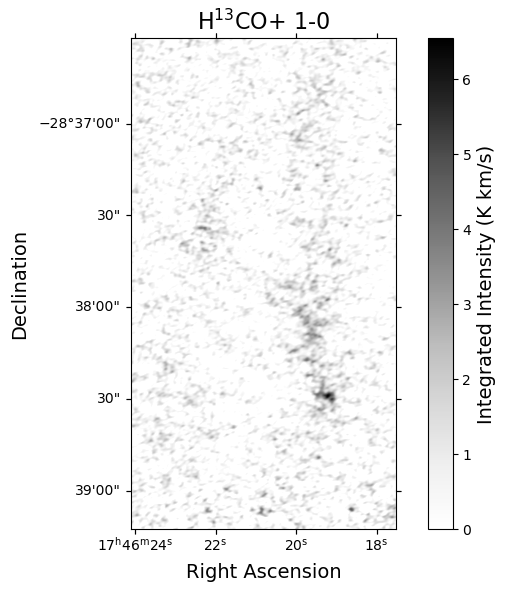

In [38]:
mom0_H13COp = plot_mom0_cutout(pos_ctr, l, w, line='H13CO+ 1-0', vmin=-56*u.km/u.s, vmax=-52*u.km/u.s)
plt.title('H$^{13}$CO+ 1-0', fontsize=16)
plt.savefig(f'{basepath}/figures/filament_mom0_H13COp_10.pdf', bbox_inches='tight')

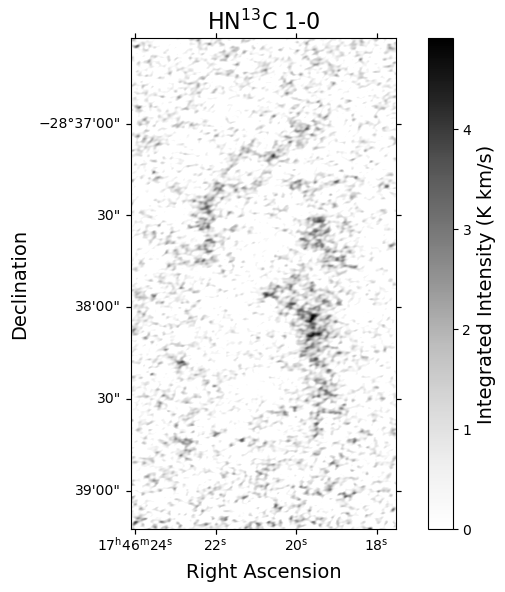

In [30]:
mom0_HN13C = plot_mom0_cutout(pos_ctr, l, w, line='HN13C 1-0', vmin=-56*u.km/u.s, vmax=-52*u.km/u.s)
plt.title('HN$^{13}$C 1-0', fontsize=16)
plt.savefig(f'{basepath}/figures/filament_mom0_HN13C_10.pdf', bbox_inches='tight')

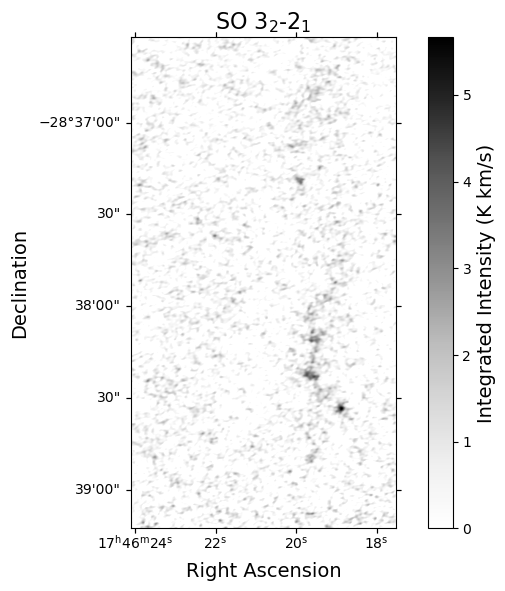

In [33]:
mom0_SO31_21 = plot_mom0_cutout(pos_ctr, l, w, line='SO 3(2)-2(1)', vmin=-56*u.km/u.s, vmax=-52*u.km/u.s)
plt.title('SO 3$_2$-2$_1$', fontsize=16)
plt.savefig(f'{basepath}/figures/filament_mom0_SO_31_21.pdf', bbox_inches='tight')

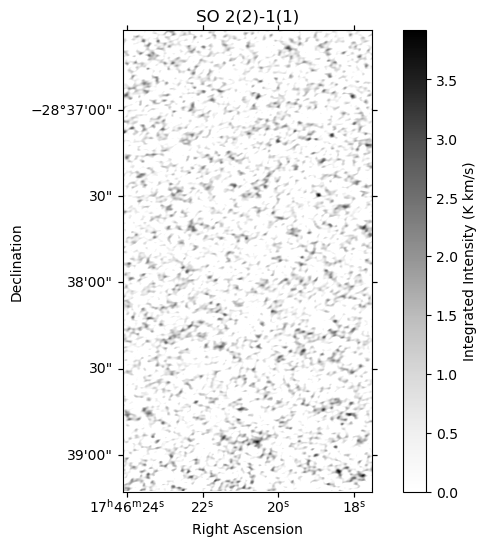

In [99]:
mom0_SO22_11 = plot_mom0_cutout(pos_ctr, l, w, line='SO 2(2)-1(1)', vmin=-56*u.km/u.s, vmax=-52*u.km/u.s)


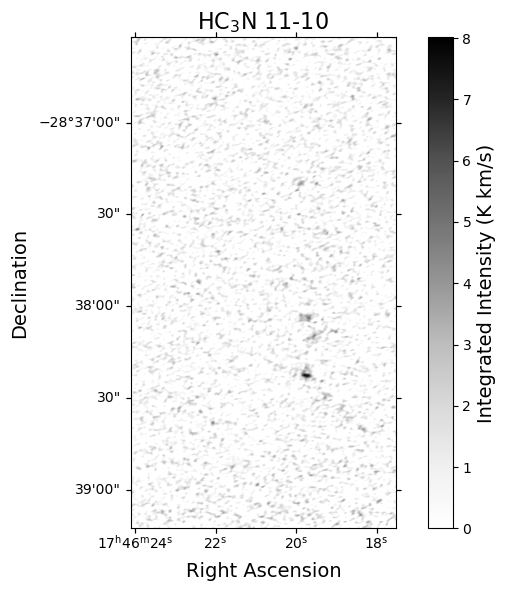

In [34]:
mom0_HC3N = plot_mom0_cutout(pos_ctr, l, w, line='HC3N 11-10', vmin=-56*u.km/u.s, vmax=-52*u.km/u.s)
plt.title('HC$_3$N 11-10', fontsize=16)
plt.savefig(f'{basepath}/figures/filament_mom0_HC3N_1110.pdf', bbox_inches='tight')

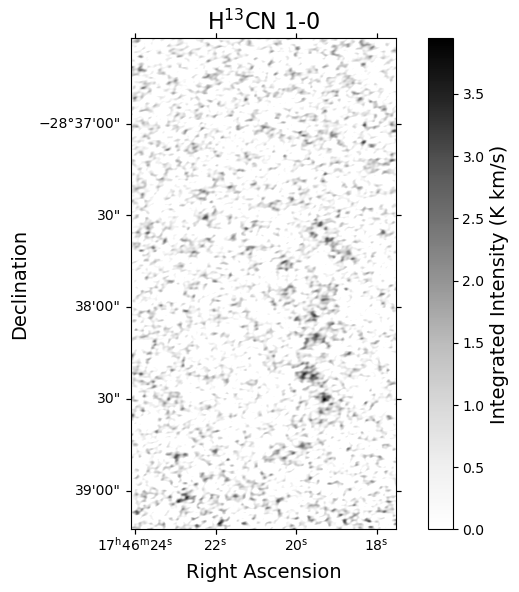

In [37]:
mom0_H13CN = plot_mom0_cutout(pos_ctr, l, w, line='H13CN 1-0', vmin=-56*u.km/u.s, vmax=-52*u.km/u.s)
plt.title('H$^{13}$CN 1-0', fontsize=16)
plt.savefig(f'{basepath}/figures/filament_mom0_H13CN_10.pdf', bbox_inches='tight')

# PV Diagrams

In [16]:
pos_ctr = SkyCoord('17:46:19.4437145447', '-28:38:18.4192304091', unit=(u.hourangle, u.deg))
l = 60*u.arcsec#3*u.arcmin#2.0*u.arcmin
w = 30*u.arcsec#1.3*u.arcmin#1.0*u.arcmin
reg_filabox_ = regions.RectangleSkyRegion(center=pos_ctr, width=w, height=l)

In [17]:
mom0_CS_cutout = get_moment0_box(pos_ctr, l, w, 'CS 2-1', vmin=-56*u.km/u.s, vmax=-52*u.km/u.s)

/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in scalar remainder
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]
/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in scalar remainder
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


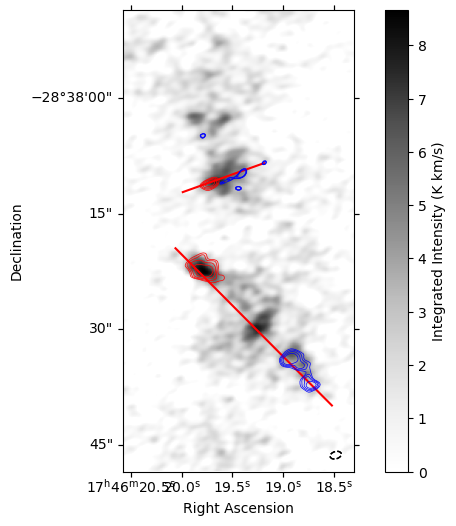

In [18]:
fig = plt.figure(figsize=(8,6))


ax = plt.subplot(111, projection=mom0_CS_cutout.wcs)
im = ax.imshow(mom0_CS_cutout.data, cmap='Greys', vmin=0)

#path1 = Path(SkyCoord(['17:46:20.0850627858', '17:46:18.3556101301'], ['-28:38:19.0294725036', '-28:38:41.3496024714'], unit=(u.hourangle, u.deg)))
path1 = Path(SkyCoord(['17:46:18.5127712028', '17:46:20.0740692721'], ['-28:38:39.9953073102', '-28:38:19.3409070189'], unit=(u.hourangle, u.deg)))
path1.show_on_axis(ax, spacing=1, color='r')
plot_sio_mom0_filament(ax, clump1, 25*u.arcsec, 25*u.arcsec, percents=[98, 98.5, 99, 99.5])


#path2 = Path(SkyCoord(['17:46:18.8955905800', '17:46:19.7143068392'], ['-28:38:23.3620017785', '-28:38:35.8113444981'], unit=(u.hourangle, u.deg)))
#path2.show_on_axis(ax, spacing=1, color='r')

path3 = Path(SkyCoord(['17:46:19.1810032784','17:46:19.9997717313'],['-28:38:08.4187172916','-28:38:12.2642134752'], unit=(u.hourangle, u.deg)))
#Path(SkyCoord(['17:46:19.2548767072', '17:46:19.9161884949'], ['-28:38:08.6882920122', '-28:38:11.4465321463'], unit=(u.hourangle, u.deg)))
path3.show_on_axis(ax, spacing=1, color='r')
plot_sio_mom0_filament(ax, clump2, 12*u.arcsec, 12*u.arcsec, percents=[98, 98.5, 99, 99.5])

ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')
#ax.set_title(mol['Line'].value[0])

cbar = plt.colorbar(im)
cbar.set_label('Integrated Intensity (K km/s)')


In [19]:
spec_tab = Table.read(f'{basepath}/analysis/linelist.csv')
lines = spec_tab['Line']
mol = spec_tab[spec_tab['Line']=='CS 2-1']
spw = mol['12m SPW'][0]
fn = f'/orange/adamginsburg/jwst/cloudc/alma/ACES/uid___A001_X15a0_X1a8.s38_0.Sgr_A_star_sci.spw{spw}.cube.I.iter1.image.pbcor.fits'

cube = SpectralCube.read(fn)
subcube = cube.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=mol['Rest (GHz)']*u.GHz).spectral_slab(-100*u.km/u.s, 0*u.km/u.s)

In [20]:
spec_tab = Table.read(f'{basepath}/analysis/linelist.csv')
lines = spec_tab['Line']
mol = spec_tab[spec_tab['Line']=='SiO 2-1']
spw = mol['12m SPW'][0]
fn = f'/orange/adamginsburg/jwst/cloudc/alma/ACES/uid___A001_X15a0_X1a8.s38_0.Sgr_A_star_sci.spw{spw}.cube.I.iter1.image.pbcor.fits'
mom0_SiO = get_moment0(mol['Rest (GHz)']*u.GHz, -56*u.km/u.s, -52*u.km/u.s, fn)

cube_SiO = SpectralCube.read(fn)
subcube_SiO = cube_SiO.with_spectral_unit(u.km/u.s, velocity_convention='radio', rest_value=mol['Rest (GHz)']*u.GHz).spectral_slab(-100*u.km/u.s, 0*u.km/u.s)

In [21]:
#subcube.allow_huge_operations = True
#subcube = subcube.to(u.K)
#
#subcube_SiO.allow_huge_operations = True
#subcube_SiO = subcube_SiO.to(u.K)

In [22]:
pvdiagram1 = extract_pv_slice(cube=subcube, path=path1, spacing=1)


In [23]:
pvdiagram1_SiO = extract_pv_slice(cube=subcube_SiO, path=path1, spacing=1)


/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in scalar remainder
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


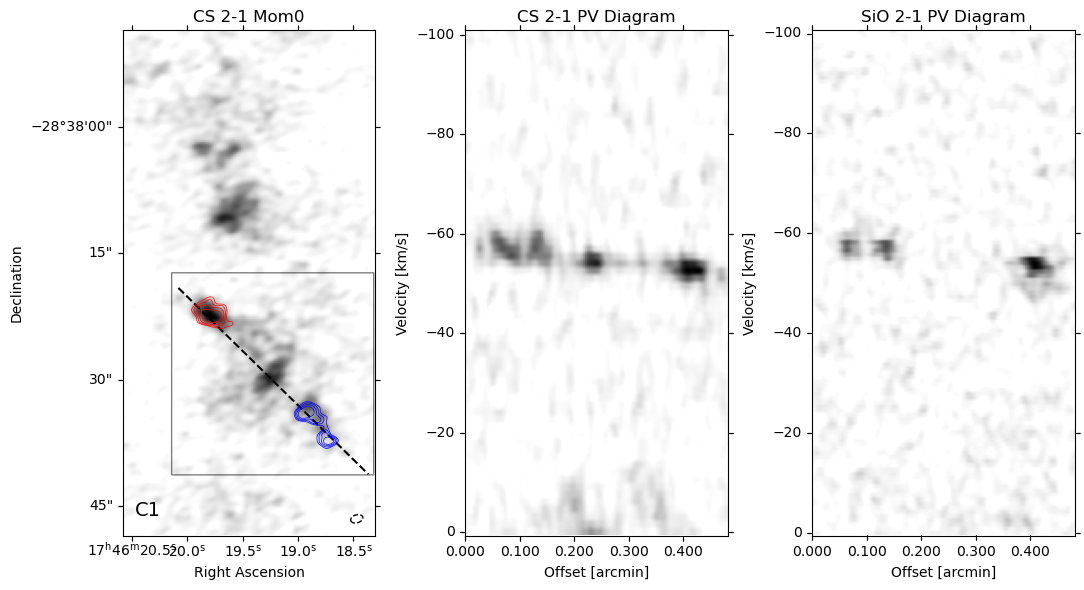

In [31]:
fig = plt.figure(figsize=(11, 6))

ax1 = plt.subplot(131, projection=mom0_CS_cutout.wcs)
ax1.imshow(mom0_CS_cutout.data, cmap='Greys', vmin=0)

path1 = Path(SkyCoord(['17:46:20.0850627858', '17:46:18.3556101301'], ['-28:38:19.0294725036', '-28:38:41.3496024714'], unit=(u.hourangle, u.deg)))
path1.show_on_axis(ax1, spacing=1, color='k', linestyle='--')
plot_sio_mom0_filament(ax1, clump1, 24*u.arcsec, 24*u.arcsec, percents=[98, 98.5, 99, 99.5])
reg_clump1 = regions.RectangleSkyRegion(center=clump1, width=24*u.arcsec, height=24*u.arcsec)
reg_clump1.to_pixel(mom0_CS_cutout.wcs).plot(ax=ax1, edgecolor='black', alpha=0.5, facecolor='none')
#plot_sio_mom0_filament(ax1, clump2, 22*u.arcsec, 22*u.arcsec, percents=[98, 98.5, 99, 99.5])
ax1.text(0.1, 0.05, 'C1', color='k', fontsize=14, transform=ax1.transAxes, ha='center', va='center')

ax1.set_xlabel('Right Ascension')
ax1.set_ylabel('Declination')
ax1.set_title('CS 2-1 Mom0')

ax2 = plt.subplot(132, projection=WCS(pvdiagram1.header))
ax2.imshow(pvdiagram1.data, cmap='Greys', vmin=0)

ax2.coords[1].set_format_unit(u.km/u.s)
ax2.coords[0].set_format_unit(u.arcmin)
ax2.set_xlabel('Offset [arcmin]')
ax2.set_ylabel('Velocity [km/s]')
ax2.set_aspect('auto')
ax2.set_title('CS 2-1 PV Diagram')

ax3 = plt.subplot(133, projection=WCS(pvdiagram1_SiO.header))
ax3.imshow(pvdiagram1_SiO.data, cmap='Greys', vmin=0)

ax3.coords[1].set_format_unit(u.km/u.s)
ax3.coords[0].set_format_unit(u.arcmin)
ax3.set_xlabel('Offset [arcmin]')
ax3.set_ylabel('Velocity [km/s]')
ax3.set_aspect('auto')
ax3.set_title('SiO 2-1 PV Diagram')

plt.tight_layout()
plt.savefig(f'{basepath}/figures/pv_diagrams_filament_outflow1.pdf', bbox_inches='tight')

In [32]:
basepath

'/orange/adamginsburg/jwst/cloudc/'

In [33]:
pvdiagram3 = extract_pv_slice(cube=subcube, path=path3, spacing=1)


In [34]:
pvdiagram3_SiO = extract_pv_slice(cube=subcube_SiO, path=path3, spacing=1)


/orange/adamginsburg/miniconda3/envs/python312/lib/python3.12/site-packages/casa_formats_io/casa_dask.py:247: RuntimeWarning: divide by zero encountered in scalar remainder
  factors = [f for f in range(stacks[dim] + 1) if stacks[dim] % f == 0]


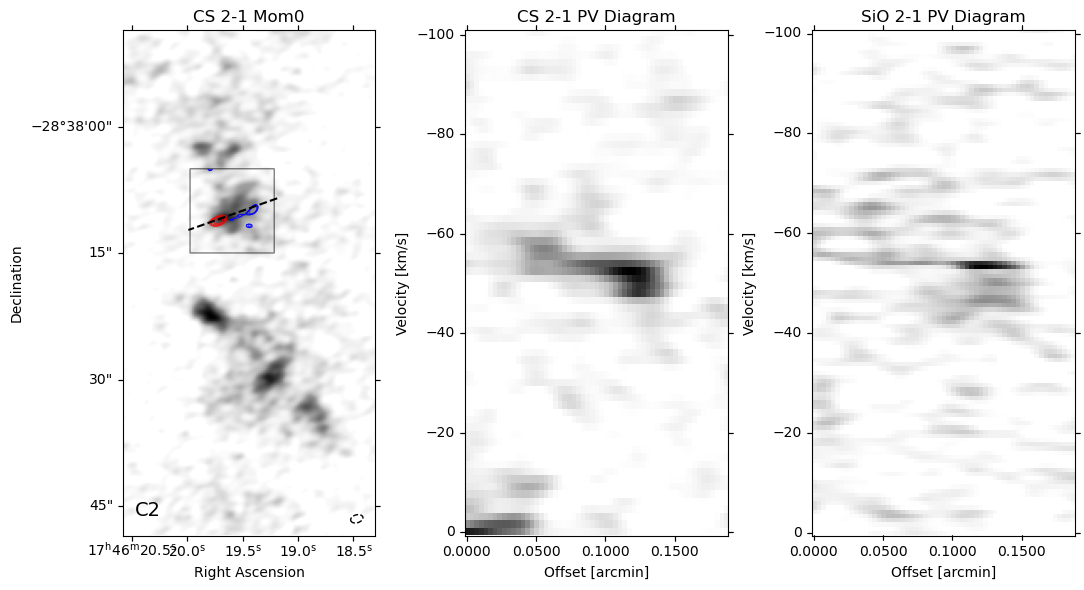

In [35]:
fig = plt.figure(figsize=(11, 6))

ax1 = plt.subplot(131, projection=mom0_CS_cutout.wcs)
ax1.imshow(mom0_CS_cutout.data, cmap='Greys', vmin=0)

plot_sio_mom0_filament(ax1, clump2, 10*u.arcsec, 10*u.arcsec, percents=[98, 98.5, 99, 99.5])
path3.show_on_axis(ax1, spacing=1, color='k', linestyle='--')
reg_clump2 = regions.RectangleSkyRegion(center=clump2, width=10*u.arcsec, height=10*u.arcsec)
reg_clump2.to_pixel(mom0_CS_cutout.wcs).plot(ax=ax1, edgecolor='black', alpha=0.5, facecolor='none')
ax1.text(0.1, 0.05, 'C2', color='k', fontsize=14, transform=ax1.transAxes, ha='center', va='center')

ax1.set_xlabel('Right Ascension')
ax1.set_ylabel('Declination')
ax1.set_title('CS 2-1 Mom0')

ax2 = plt.subplot(132, projection=WCS(pvdiagram3.header))
ax2.imshow(pvdiagram3.data, cmap='Greys', vmin=0)
ax2.coords[1].set_format_unit(u.km/u.s)
ax2.coords[0].set_format_unit(u.arcmin)
ax2.set_xlabel('Offset [arcmin]')
ax2.set_ylabel('Velocity [km/s]')
ax2.set_aspect('auto')
ax2.set_title('CS 2-1 PV Diagram')

ax3 = plt.subplot(133, projection=WCS(pvdiagram3_SiO.header))
ax3.imshow(pvdiagram3_SiO.data, cmap='Greys', vmin=0)
ax3.coords[1].set_format_unit(u.km/u.s)
ax3.coords[0].set_format_unit(u.arcmin)
ax3.set_xlabel('Offset [arcmin]')
ax3.set_ylabel('Velocity [km/s]')
ax3.set_aspect('auto')
ax3.set_title('SiO 2-1 PV Diagram')


plt.tight_layout()
plt.savefig(f'{basepath}/figures/pv_diagrams_filament_outflow2.pdf', bbox_inches='tight')